# Modelos e Estratégias de Trading
## Ajustando um modelo VAR ao Dolar Futuro

Uirá Caiado. 05 de Setembro, 2016

**Resumo**

*Uma das principais necessidades quando falamos trading é realizar algum tipo de previsão sobre o estado futuro do instrumento operado para que possamos posicionar nossas ofertas. Como um dos objetivos da análise de séries temporais multivariadas é a realização de forecasts, nesta atividade vou implementar um modelo desta classe chamado Vetor Auto Regressivo (VAR). Vou ajustar o modelo aos retornos e informações de book da PETR4 e analisar a performance realizando um back-test em uma parte dos dados coletados que ainda não tenha sido utilizada.*

## 1. Introdução

Quando operamos, frequentemente preciasamos tomar decisões como manter uma posição ou não, comprar, vender, não fazer nada. Se possuírmos uma série temporal de observações relacionadas à variável de interesse (o instrumento ou spread operado, por exemplo) e se estes dados possuírem informação sobre a dinâmica dela, Lutkepohl afirma que é razoável utilizarmos para a previsão alguma função dos dados já coletados, de maneira que:

$$\hat{y}_{K,\, T+1} = f \left( y_{1, T}, y_{2, T}, y_{1, T-1}, \dots \right)$$

Onde $y_{k, t}$ é uma variável aleatória, onde $t$ denota o índice dela no tempo e $k$, o índice da própria variável. A equação de *forecast* acima implica que pode haver interdependência entre as varíaveis utilizadas. Estas multiplas variáveis podem ser os retornos de diferentes ativos, variáveis macro-econômica e etc.

Dado que a série temporal é um conjunto de variáveis aleatórias, assumimos que essa série é gerada por um processo estocástico com um espaço de probabilidade $\left ( \Omega, \, \mathscr{F}, \, P \right )$ associado, onde $\Omega$ é o espaço amostral, $\mathscr{F}$ ou $\sigma-algebra$ representa todos os subconjuntos possíveis de $\Omega$ e $P$, a medida de probabilidade. Definimos que uma variel aleatória é uma função que associa elementos de um espaço amostral $\Omega$ a valores no conjunto de números Reais.

Assim, assumindo que os nossos dados são realizações de variáveis aleatórias, que a mesma processo gerador de dados prevalece sobre todo o período $T$ (ainda que não conhecido), que funções lineares (nos parâmetros) são relativamente fáceis de lidar, podemos escrever um processo auto regressivo vetorial de forma que:

$$y_t = \upsilon + A_q y_{t-1} +  \dots + A_p y_{t-p} + u_t$$

onde $y_t := \left( y_{1t}, \dots, y_{Kt}\right)'$ é um vetor de variáveis aleatórias, $\upsilon := \left( \upsilon_{t}, \dots, \upsilon_{K}\right)'$ é um vetor de constantes, $A$ é uma matriz quadrada de parâmetros e $u_t = \left( u_{1t}, \dots, u_{Kt}\right)$ é uma sequência dops erros de previsão, tidos como *iid* com média $0$. Segundo notas de aula, isto é equivalente a dizer que toda a informação útil contida no  $\sigma-algebra$ foi incorporada ao $y_t$ e não existem erros sistemáticos nos *forecasts*.

Neste trabalho vou estimar os parâmetros do modelo acima, que também é chamado de modelo de vetor auto regressivo (VAR). Dado que é um AR, é esperado que os dados utilizados como input sejam estacionários (primeiro e segundo momento invariante) e que o modelo produzido seja estável (todos os autovalores de $A$ possuem módulo menor do que 1).

Depois vou utilizá-lo para realizar previsões (aqui também referenciados como *forecast*) e estimar os critérios de seleção: erro de predição (FPE), critério de informação de Akaike (AIC), critério de Hannan-Quinn e critério de Schwarz. Por fim, vou ajustar o modelo à alguns dados atuais de mercado.

## 2. Implementando o Modelo

Nesta sessão vou detalhar o processo de estimação dos parâmetros, *forecast* e o cálculo dos critérios de seleção.

### 2.1. Estimando os Parâmetros

Dado que o modelo foi descrito como uma relação linear entre as variáveis, podemos estimar os parâmetros do modelo através da minimização dos erros quadrados (de estimação) utilizando o estimador de mínimos quadrados multivariado. Primeiro, assumindo que a série temporal $y_1, ..., y_T$ de tamanho T e "largura" K (o número de varipaveis disponíveis), de forma que:

                   0         1         2         3         4
2014-01-01  0.004082  0.007782  0.033859  0.023865  0.041760
2014-01-02  0.012377  0.019575  0.052446  0.056654 -0.010573
2014-01-03 -0.006921 -0.011853 -0.005707 -0.017716 -0.019980
2014-01-04  0.000579  0.005753 -0.020576 -0.004274 -0.036814
2014-01-05  0.001156  0.011407 -0.003350  0.003459  0.000000



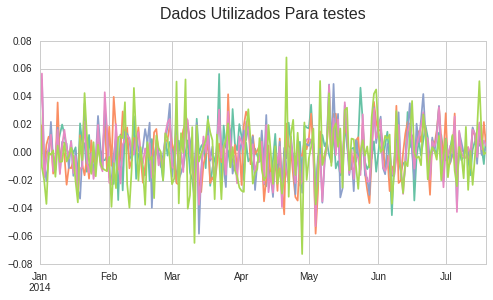

In [8]:
import pandas as pd
df = pd.read_excel('data/VAR3_inputs_e_outputs.xlsx', header=None)
l_index = pd.date_range(start= '01/01/2014', end='01/12/2016')
df.index = l_index[:df.shape[0]]
print df.head()
print
ax = df.plot(legend=False)
ax.set_title('Dados Utilizados Para testes\n', fontsize=16);

Onde as colunas representam $K$ e as linhas, $T$. Também vamos assumir que os dados utilizandos são estacionários (o que realmente parece, olhando para o gráfico). Definindo:

$$
\begin{aligned}
Y &:= \left(  y_1, \dots, y_T \right)  \;\;\;\;\; &\left(K \times T \right)\\
B &:= \left(  \upsilon,\, A_1 \dots, A_p \right)  \;\;\;\;\; &\left(K \times (Kp + 1) \right)\\
Z_t &:= \left(  1, y_t, \dots, y_{t-p+1} \right)'  \;\;\;\;\; &\left(1 \times (Kp + 1) \right)\\
Z &:= \left(  Z_0, \dots, Z_T \right)  \;\;\;\;\; &\left((Kp + 1) \times T \right)
\end{aligned}
$$

Utilizando notação de mtraiz, reescrevemos o var como sendo da forma $Y = B Z + U$, implicando que os residuos são da forma $U = Y - BZ$. Para determinar o estimador de mínimos quadrados (*Econometric Methods with Application in Business and Economics*, pg. 121), escrevemos a soma do quadrado dos resíduos como:

$$
\begin{aligned}
S(b) &= \sum U^2 = U'U = \left( Y - BZ \right)' \left( Y - BZ \right)\\
     &= Y'Y - Y'BZ - B'Z'Y + B'Z'ZB\\
\end{aligned}
$$

Como $Y'ZB = B'Z'Y$, podemos reescrever a equação acima como:

$$S(b) = Y'Y - 2B'Z'Y + B'Z'ZB$$

Derivando em relação a $B$ e igualando a zero, finalmente chegamos que:

$$
\begin{aligned}
S(b) &= \sum U^2 = U'U = \left( Y - BZ \right)' \left( Y - BZ \right)\\
     &= Y'Y - Y'BZ - B'Z'Y + B'Z'ZB\\
\end{aligned}
$$

Foi criada uma biblioteca chamada *var_model* no repositório deste arquivo implementando este modelo. Os valores serão comparados com os valores obtidos com implementação deste modelo da biblioteca [*statsmodel*](http://statsmodels.sourceforge.net/), do Python. Vamos começar expondo os valores de matriz $B$:

In [9]:
import var_model.vector_autoregression as var
reload(var)
self = var.VectorAutoregression(df)
self.fit(3)

In [32]:
# imprime matrizes A
import pandas as pd
for idx, A in enumerate(self.na_A):
    print "A{}:\n {}".format(idx + 1, pd.DataFrame(A))
    print 
        

A1:
           0         1         2         3         4
0 -0.043374  0.128951 -0.127479  0.049648 -0.071250
1  0.005321  0.178780  0.003759  0.032509 -0.072283
2  0.008242  0.115180 -0.050708  0.007212 -0.041946
3  0.035804  0.166959  0.048654 -0.117873 -0.049864
4 -0.064091 -0.059743 -0.097786  0.268141 -0.054190

A2:
           0         1         2         3         4
0  0.013431  0.001495 -0.242662  0.245055 -0.075217
1 -0.244118 -0.004717 -0.345717  0.413840 -0.032270
2 -0.047898  0.179970 -0.487353  0.295174  0.055272
3 -0.043729  0.159101 -0.365092  0.193884  0.068610
4 -0.028104  0.096378 -0.391956  0.162951 -0.030571

A3:
           0         1         2         3         4
0 -0.044115  0.015434  0.056729 -0.180469  0.065909
1 -0.075600 -0.076008  0.070572  0.017278  0.042417
2 -0.110870  0.027031 -0.034428 -0.013438 -0.022812
3 -0.040539  0.032051 -0.016870 -0.037124 -0.001811
4 -0.046125 -0.081289  0.247950 -0.131097 -0.025088



O matriz $\Sigma_U$ foi estimado direto pela definição $\tilde{\Sigma_U} = \mathbf{E} \left[ u_t u_t '\right]$, ou seja, calculei a matriz $U = Y - BZ$ e fiz o dot product dela por ela transposta e dividi por T (por causa do operador Esperança). Depois ajustei o resultado pelo grau de liberdade do modelo, de maneira que $\hat{\Sigma}_{U} = \frac{T}{T - Kp -1} \tilde{\Sigma}_{U}$.

In [31]:
# imprime matriz Sigma_U
import pandas as pd
print "Sigma_U:\n {}".format(pd.DataFrame(self.na_Sigma))

Sigma_U:
           0         1         2         3         4
0  0.000195  0.000068  0.000056  0.000077  0.000064
1  0.000068  0.000283  0.000154  0.000166  0.000117
2  0.000056  0.000154  0.000309  0.000255  0.000126
3  0.000077  0.000166  0.000255  0.000267  0.000130
4  0.000064  0.000117  0.000126  0.000130  0.000461


Agora vamos comparar estes valores com os valores obtidos pela implementação do *statsmodel*.

In [33]:
from statsmodels.tsa.api import VAR
import statsmodels.tsa.vector_ar.util as util
model = VAR(df)
results = model.fit(3)
aux = util.get_var_endog(df.values, 3)

In [34]:
# calcula erros para implementacao do statsmodel
print "error in Z: {:0.8f}".format(sum(sum(abs(self.na_Z.T - aux))))
print "error in A: {:0.8f}".format(sum(sum(sum(abs(self.na_A - results.coefs)))))
print "error in B: {:0.8f}".format(sum(sum(abs(self.na_betahat - results.params.values))))
print "error in Sigma_U: {:0.8f}".format(sum(sum(abs(self.na_Sigma - results.sigma_u.values))))

error in Z: 0.00000000
error in A: 0.00000000
error in B: 0.00000000
error in Sigma_U: 0.00000000


Como pode-se ver, até a oitava casa decimal, os valores obtidos foram identicos ao obtidos pela biblioteca benchmark.

### 2.2. Forecast

Segundo notas de aula, para se afirmar o que ocorrerá no futuro $\left (  y_1, ..., y_k \right )$, tendo um processo $VAR(p)$ ajustado a um conjunto de dados $\Omega_t = \{ y_s \mid s \leq t \}$ para um horizonte de tempo $h$, precisamos determinar qual o *forecast* ótimo determinando aquele que minimiza uma função custo associada à seus erros (quadráticos médios - MSE na sigla em inglês). O preditor que minimiza estes erros é a esperança condicional (Lutkepohl, p. 33)

$$\mathbf{E}\left [ y_{t+h} \right ] := \mathbf{E}\left [ y_{t+h} \mid  \Omega_t \right ] = \mathbf{E}\left [ y_{t+h} \mid  \{ y_s \mid s \leq t \} \right ]$$

Lutkepohl ainda demonstra que a otimização da esperança condicional impica que:

$$
\mathbf{E}\left [ y_{t+1} \right ] = \upsilon + A_1 y_t + ... + A_p y_{t-p + 1} \\
\mathbf{E}\left [ y_{t+2} \right ] = \upsilon + A_1 \mathbf{E}\left [ y_{t+1} \right ] + A_2 y_t + ... + A_p y_{t-p + 2} \\
\vdots
$$


Aplicando este método e comparando com a implementação benchmark, chegamos que:

In [36]:
my_forecast, my_max, my_min = self.forecast(df[-3:].values, 1)
na_forecast = results.forecast_interval(df[-3:].values, 1)

In [46]:
# previsão para 1 periodo para cada variavel
print "error in Forecast: {:0.8f}\n".format((sum(abs(my_forecast - na_forecast[0][0]))))
print pd.Series(my_forecast)

error in Forecast: 0.00000000

0    0.001801
1    0.006724
2    0.006905
3    0.005442
4    0.000813
dtype: float64


### 2.3. Intervalo de Confiança

Segundo Lutkepohl (p. 38), o erro de previsão (e consequentemente, o intervalo de confiança) pode ser obtido através da matriz de covariância dos erros (ou, da sigla em inglês, MSE matrix). Porém, quando se deseja realizar *forecasts* para mais de um período, é necessário definir também a matriz de coeficientes de Média Móvel (MA), que para um VAR(2) fica:

$$
\phi_1 = A_1 \\
\phi_2 = \phi_1 A_1 + A2 \\
\phi_3 = \phi_2 A_1 + \phi_1 A2 \\
\vdots \\
\phi_i = \phi_{i-1} A_1 + \phi_{i-2} A_2
$$

Assim, a matriz MSE de *forecast* são obtidas recursivamente aplicando

$$
\Gamma_y(0) = \Sigma_y = \sum_{i=0}^{\infty} \phi_i \Sigma_u \phi_i^{'}
$$

Sendo que:
$$
\Sigma_y (1) = \Sigma_u \\
\Sigma_y (2) = \Sigma_u + \phi_{1} \Sigma_u \phi_{1}' \\
\Sigma_y (3) = \Sigma_y (2) + \phi_{2} \Sigma_u \phi_{2}' \\
\vdots
$$

O $h$ em $\Sigma_y (h)$ se refere a quantos passos para frente se aplica a função de forecast. Como o modelo de VAR assume que os erros $u_t \sim N \left( 0, \, \Sigma_y(h) \right)$, podemos assumir que o erro de *forecast* também é normalmente distribuído. Com este pressuposto, podemos definir um [intervalo de confiança](https://en.wikipedia.org/wiki/Confidence_interval) na forma: 
$$\left[ y_{k, \, t} (h) - z_{(\alpha / 2)} \sigma_k (h), \, \, \, \, \, y_{k, \, t} (h) + z_{(\alpha / 2)} \sigma_k (h) \right]$$

Onde $\sigma(h)$ é a raiz quadrada do ** *k-ésimo* elemento da diagonal** $\Sigma_y(h)$. Assim, seguindo exemplo do livro, se tivermos:
$$
\Sigma_y (1) =
\begin{pmatrix}
  \textbf{2.25} & 0 & 0 \\
  0 & \textbf{1.0} & .5 \\
  0 & .5 & \textbf{.74}
\end{pmatrix}
$$

Os intervalos de confiança são dados por:

$$
y_{1, t} (1) \pm z_{(\alpha / 2)} \sqrt{2.25} \\
y_{2, t} (1) \pm z_{(\alpha / 2)} \sqrt{1.0} \\
y_{3, t} (1) \pm z_{(\alpha / 2)} \sqrt{.74}
$$

Assim, vamos calcular os intervalos de confiança para 3 perídos para frente e comparar com a implementação do *benchmark*.

In [47]:
import var_model.vector_autoregression as var
import numpy as np
import pandas as pd
reload(var)
self = var.VectorAutoregression(df)
self.fit(3)

In [48]:
my_forecast, my_max, my_min = self.forecast(df[-5:].values, 3)
na_forecast, na_min, na_max = results.forecast_interval(df[-3:].values, 3)

In [49]:
print "Erro no limite inferior: {:0.7f}".format(sum(abs(na_min[-1] - my_min)))
print "Erro no Forecast: {:0.7f}".format(sum(abs(na_forecast[-1] - my_forecast)))
print "Erro no limite superior: {:0.7f}".format(sum(abs(na_max[-1] - my_max)))
print '\n\n'
df_plot = pd.DataFrame([my_min, na_min[-1]], index=['meu modelo', 'statsmodel'])
df_plot.index.name = 'Minimo'
print str(df_plot)
print ''

df_plot = pd.DataFrame([my_max, na_max[-1]], index=['meu modelo', 'statsmodel'])
df_plot.index.name = 'Maximo'
print df_plot

Erro no limite inferior: 0.0030550
Erro no Forecast: 0.0000000
Erro no limite superior: 0.0030550



                   0         1         2         3         4
Minimo                                                      
meu modelo -0.030019 -0.035569 -0.037285 -0.034497 -0.046392
statsmodel -0.030496 -0.036200 -0.037916 -0.035087 -0.047116

                   0         1         2         3         4
Maximo                                                      
meu modelo  0.026364  0.033363  0.034616  0.032315  0.040077
statsmodel  0.026841  0.033994  0.035248  0.032906  0.040801


Apesar do *forecast* ter ficado igual à implementação do *statsmodel*, os intervalos encontrados foram um pouco diferentes. Porém o erro em relação a implementação do *benchmark* foram simétricos, o que sugere que utilizaram um método de estimação diferente do implementado aqui.

### 2.4. Selecionando a Ordem do VAR

Como visto, além dos dados anteriores, o modelo VAR tem mais uma variável: A ordem do processo auto regressivo. Segundo notas de aula, devemos escolher esta ordem de maneira que as projeções tenham a melhor precisão (ou o menor erro quadrático médio). Lutkepohl argumenta que não há uma única maneira de se fazer isso. Uma opção, por exemplo, é utilizar o critério de erro de predição final (FPE), definido como:

$$FPE(m) = \left[ \frac{T + Km + 1}{T - Km -1} \right]^{K} \left |  \Sigma_u(m) \right | $$

Onde $\left |  . \right |$ é o determinante e $m$ a ordem testada (p. 147, Lutkepohl). Outro critério é O Critério de informação de Akaike (AIC), definido como:

$$AIC(m) = \ln \left |  \Sigma_u(m) \right | + \frac{2mK^2}{T}$$

Uma terceira opção é o Critério de Hannan-Quinn, que possui propriedades amostrais interessantes (consistência, neste caso). Ele é da forma:

$$HQ(m) = \ln \left |  \Sigma_u(m) \right | + \frac{2\ln \ln T}{T}mK^2$$

A última opção implementada será outro com a mesma propriedade assintótica do critério anterior. O critério de Schwarz (SC ou BIC), é da forma:

$$SC(m) = BIC(m) = \ln \left |  \Sigma_u(m) \right | + \frac{\ln T}{T}mK^2$$

In [144]:
import var_model.vector_autoregression as var
import numpy as np
import pandas as pd
reload(var)
self = var.VectorAutoregression(df)

In [145]:
self.select_order(10)

Ordem com menor valor para cada Critério:
  Critério FPE:  		Ord. 1
  Critério AIC:  		Ord. 1
  Critério HQ:  		Ord. 1
  Critério SC(BIC):  		Ord. 1




           AIC  FPE       HQ  SC(BIC)
Ordem                                
1     -42.6786  0.0 -42.5111 -42.2648
2     -42.5899  0.0 -42.2538 -41.7596
3     -42.2861  0.0 -41.7801 -41.0361
4     -42.0422  0.0 -41.3651 -40.3697
5     -41.7619  0.0 -40.9124 -39.6638
6     -41.5320  0.0 -40.5089 -39.0053
7     -41.2570  0.0 -40.0589 -38.2986
8     -40.9928  0.0 -39.6185 -37.5996
9     -40.7496  0.0 -39.1978 -36.9184
10    -40.4579  0.0 -38.7272 -36.1855


## 3. Aplicando o modelo VAR

Nesta seção vamos tentar aplicar o modelo à dado de alta frequência de Dolar Futuro. Os dados serão agrupados em intervalores de 10 segundos e, ao invés de ajustar o modelo aos retornos, o modelo será aplicado à primeira diferença das variáveis selecionadas.

### 3.1. Order Flow Imbalance

bla bla


## 4. Conclusão

bla bla




## 5. Últimas Considerações

bla bla

## Referências

1. H. Lütkepohl.  *New Introduction to Multiple Time Series Analysis*. Springer-Verlag, 2005. [*link*](http://www.springer.com/br/book/9783540401728)
2. Heij, C. and de Boer, P. and Franses, P.H. and Kloek, T. and van Dijk, H.K. and Rotterdam.  *Econometric Methods with Applications in Business and Economics*. OUP Oxford, 2004. [*link*](https://books.google.com.br/books?id=hp4vQZZHfbUC)


*Style notebook and change matplotlib defaults*

In [1]:
#loading style sheet
from IPython.core.display import HTML
HTML(open('ipython_style.css').read())

In [2]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2", 10))